### Sentiment Analysis using FNet

#### The following paper (https://arxiv.org/pdf/2105.03824) explains the mathmatical part of this model
#### Data Link: https://www.kaggle.com/code/bilalhasan12/sentiment-analysis-using-fnet/notebook

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import keras_nlp
import keras
import warnings
warnings.filterwarnings('ignore')

#### Define some hyperparameters

In [5]:
batch_size = 64
vocab_size = 15000
seq_max_length = 512
embed_dim = 128
inter_dim = 512
lr = 0.001
epochs = 2

#### Read the data

In [6]:
train_dataset = pd.read_csv('Data/train.csv')
test_dataset = pd.read_csv('Data/test.csv')
train_dataset.head()

,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


#### Insert column headings

In [7]:
train_dataset.columns = ['target', 'title', 'text']
test_dataset.columns = ['target', 'title', 'text']

train_dataset.head()

,target,title,text
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


#### I will be using 100000 samples for training and 20000 samples for validation

In [8]:
train_dataset_small = train_dataset.head(100000)
test_dataset_small = test_dataset.head(20000)

#### Convert the labels from 1 to 0 and from 2 to 1

In [9]:
train_dataset_small['target'] = train_dataset_small['target'].map({1:0, 2:1})
test_dataset_small['target'] = test_dataset_small['target'].map({1:0, 2:1})
train_dataset_small.head()

,target,title,text
0,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,1,Amazing!,This soundtrack is my favorite music of all ti...
2,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,1,an absolute masterpiece,I am quite sure any of you actually taking the...


#### Check the balance between the two classes

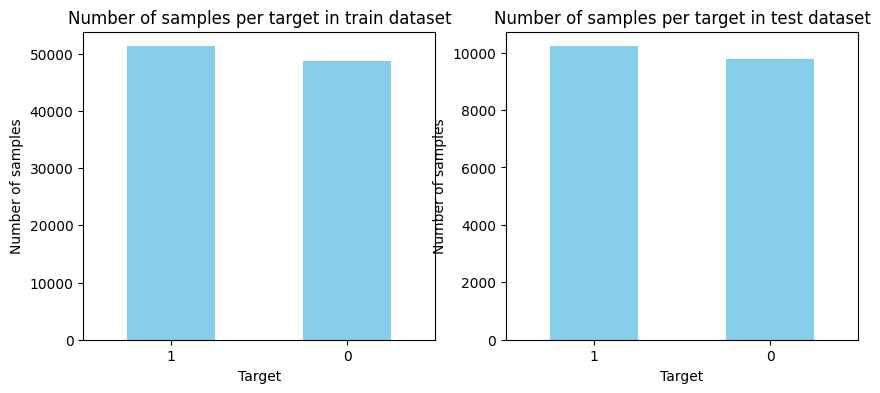

In [10]:
plt.figure(figsize=(10, 4))

train_target_counts = train_dataset_small['target'].value_counts()
plt.subplot(1, 2, 1)
train_target_counts.plot(kind='bar', color='skyblue')
plt.title('Number of samples per target in train dataset')
plt.xlabel('Target')
plt.ylabel('Number of samples')
plt.xticks(rotation=0)

test_target_counts = test_dataset_small['target'].value_counts()
plt.subplot(1, 2, 2)
test_target_counts.plot(kind='bar', color='skyblue')
plt.title('Number of samples per target in test dataset')
plt.xlabel('Target')
plt.ylabel('Number of samples')
plt.xticks(rotation=0)
plt.show()

#### Convert the dataframes into a tensorflow dataset objects

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((train_dataset_small['text'].values, train_dataset_small['target'].values))
train_ds = train_ds.shuffle(1000).batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((test_dataset_small['text'].values, test_dataset_small['target'].values))
test_ds = test_ds.shuffle(1000).batch(batch_size)

2025-04-27 12:55:51.881955: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


#### Convert the text to lowercase

In [12]:
train_ds = train_ds.map(lambda x, y: (tf.strings.lower(x), y))
test_ds = test_ds.map(lambda x, y: (tf.strings.lower(x), y))

### Tokenize the data
#### We will use word piece tokenization. First, create our vacabulary from train_ds

In [13]:
def create_vocab(dataset, vocab_size, reserved_tokens):
    text = dataset.unbatch().map(lambda x,y: x)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    text.batch(1000).prefetch(2),
    vocabulary_size=vocab_size,
    reserved_tokens=reserved_tokens,
    )
    return vocab

reserved_tokens = ["[PAD]", "[UNK]"]

vocab = create_vocab(train_ds, vocab_size, reserved_tokens)
vocab [1000:1010]

2025-04-27 12:55:54.390925: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


['dull',
 'rating',
 'brilliant',
 'general',
 'mostly',
 'moving',
 'father',
 'scary',
 'forget',
 'upon']

In [14]:
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    lowercase=False,
    sequence_length=seq_max_length,
)

### Lets take an example from train_ds and tokenize it

In [15]:
sentence = train_ds.take(1).get_single_element()[0][0]
tokens = tokenizer(sentence)

print("Sentence: ", sentence)
print("Tokens: ", tokens)
print("Recovered sentence after detokenizing: ", tokenizer.detokenize(tokens))

Sentence:  tf.Tensor(b'bought this camera for christmas. had her open it first so she could film the nights party & no tapes are included! of course all stores are closed christmas day so the thing is useless until the day after. shame on sony. how much would a tape included in the packace cost them ? not included battery chargers are ....', shape=(), dtype=string)
Tokens:  tf.Tensor(
[ 217  108  638  112  534   15  153  168  735  106  169  127  181  195
  196  103 3293 1511    7  160 2622  123  904    2  107  559  126 1768
  123 2642  534  315  127  103  262  109 1103  426  103  315  182   15
 1092  119 1161   15  186  173  144   40  835  904  110  103 1521 8048
  893  176   32  118  904  711 9601  123   15   15   15   15    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    

#### Convert the input strings in train_ds and test_ds to tokens using our tokenizer object

In [16]:
train_ds = train_ds.map(lambda x, y: (tokenizer(x), y))
test_ds = test_ds.map(lambda x, y: (tokenizer(x), y))

### Define the model

In [17]:
input_ids = keras.Input(shape=(None,), dtype='int64')

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size = vocab_size,
    sequence_length = seq_max_length,
    embedding_dim = embed_dim,
    mask_zero = True,
)(input_ids)

x = keras_nlp.layers.FNetEncoder(intermediate_dim=inter_dim)(inputs=x)
x = keras_nlp.layers.FNetEncoder(intermediate_dim=inter_dim)(inputs=x)
x = keras_nlp.layers.FNetEncoder(intermediate_dim=inter_dim)(inputs=x)

x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

fnet_classifier = keras.Model(input_ids, outputs, name="fnet_classifier")

fnet_classifier.summary()

Model: "fnet_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, None, 128)      │     1,985,536 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ f_net_encoder (FNetEncoder)     │ (None, None, 128)      │       132,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ f_net_encoder_1 (FNetEncoder)   │ (None, None, 128)      │       132,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ f_net_encoder_2 (FNetEncoder)   │ (None, None, 128)      │       132,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,382,337 (9.09 MB)

 Trainable params: 2,382,337 (9.09 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [18]:
fnet_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"],
)

history = fnet_classifier.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)

Epoch 1/2


1563/1563 - 1461s - 935ms/step - accuracy: 0.8016 - loss: 0.4089 - val_accuracy: 0.8613 - val_loss: 0.3237
Epoch 2/2
1563/1563 - 1442s - 922ms/step - accuracy: 0.8818 - loss: 0.2837 - val_accuracy: 0.8648 - val_loss: 0.3225


In [19]:
import numpy as np
fnet_classifier.save('model/fnet_model.keras')
np.save('model/history.npy', history.history)